This notebook contains a PyTorch implementation for the paper "Solving stochastic differential equations and Kolmogorov equations by means of deep learning" by Christian Beck et al, original paper can be found [here](https://arxiv.org/pdf/1806.00421.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.normal import Normal as normal

In [2]:
class ItoDiffusion:
    def __init__(self, mu, sigma, N):
        # Initializing the Ito Diffusion, given as a batch of size J
        # mu    :: R^Jxd -> R^Jxd
        # sigma :: R^Jxd -> R^Jxdxd (In general, Ito diffusions can have sigma -> R^dxpxJ, i.e. we can use Brownian increments other of dimension p=/=d)
        # where J is the batch size
        # N :: Int (Number of points in discretization)
        self.mu = mu
        self.sigma = sigma
        self.N = N
    
    def sample(self, x, T):
        # Generate J samples of X_T^x
        # x :: R^Jxd
        dt        = T/self.N
        self.d    = x.size(1)
        batchsize = x.size(0)
        for i in range(self.N):
            x = x + self.mu(x)*dt + self.sigma(x)*mvn(torch.zeros(self.d), dt*torch.eye(self.d)).sample([batchsize])
        return x

In [3]:
class FCNN(nn.Module):
    def __init__(self, dim, hidden_layers,activation_fn=nn.Tanh(),neurons=None):
        # dim    :: Int (Input dimension and also neurons in each hidden layer)
        # hidden :: Int (Number of hidden layers)
        if neurons is None:
            neurons=dim
        super().__init__()
        self.model = nn.Sequential()
        self.model.add_module("Hidden 0", nn.Linear(dim,neurons))
        self.model.add_module("Batch norm 0",nn.BatchNorm1d(neurons))
        self.model.add_module("Actvation 0",activation_fn)
        for i in range(hidden_layers-1):
            self.model.add_module("Hidden "+str(i+1), nn.Linear(neurons,neurons))
            self.model.add_module("Batch norm "+str(i+1),nn.BatchNorm1d(neurons))
            self.model.add_module("Actvation "+str(i+1),activation_fn)
        self.model.add_module("Output",nn.Linear(neurons,1))


    def forward(self,x):
        # x :: R^d (Spatial point)
        
        return self.model(x)
        # I know, this makes is harder to debug comparing to running the 
        # input through each layer separately

In [4]:
def Lp_error(neural_net, a,b,d, N,p,exact_sol=None,MC=None,phi=None,ito_diffusion=None,T=None):
    # Function to compute test errors during training phase
    
    # neural_net :: FCNN (instance of neural network)
    # a          :: Float (a in [a,b]^d)
    # b          :: Float (b in [a,b]^d)
    # d          :: Int (d in [a,b]^d)
    # N          :: Int (Number of points to sample in the MC estimate)
    # p          :: Int (p in the Lp, or "max" if max norm)
    
    # IF WE HAVE EXACT SOLUTION
    # exact_sol  :: RxR^d -> R (exact solution of the PDE)
    
    # IF WE DO NOT HAVE EXACT SOLUTION
    # MC            :: Int (MC samples to use Feynman-Kac on N points)
    # phi           :: Function R^d -> R (Initial condition)
    # ito_diffusion :: ItoDiffusion (Relevant instance from ItoDiffusion class)
    # T             :: Float (Time value which we are approximating for)
    
    # Output     :: (Float, Float) (Tuple with error and relative error)
    
    
    spatial_points = (a-b)*torch.rand(N,d) + b
    if exact_sol:
        # if we have the exact solution, we just compute it for the N input points
        u_exact = exact_sol(spatial_points)
        
        
    else:
        # if we do not have the exact solution, we use Feynman-Kac to approximate it
        assert MC is not None,  "Input MC, amount of Monte-Carlo samples to approximate exact solution"
        assert phi is not None, "Input phi, initial condition  function  to approximate exact solution"
        assert ito_diffusion is not None, "Input ito diffusion, for use to approximate exact solution"
        assert T is not None, "Input T, for use to approximate exact solution"
        u_exact = torch.zeros(N)
        
        for i in range(MC):
            u_exact += (1/MC)*phi(ito_diffusion.sample(spatial_points,T))
        
    error = neural_net(spatial_points)[:,0] - u_exact
    if p == "max":
        return float(torch.max(torch.abs(error))), float(torch.max(torch.abs(error/torch.clamp(u_exact, min=1e-8))))
    else:
        return float((torch.mean(torch.abs(error).pow(p))).pow(1/p)), float((torch.mean(torch.abs(error/torch.clamp(u_exact, min=1e-8))).pow(p)).pow(1/p))

Step 0 Relative L1 error is 0.99992 Relative L2 error is 0.99991, Relative L∞ error is 1.00070, in 0.1752 s
Step 50 Relative L1 error is 0.97682 Relative L2 error is 0.97674, Relative L∞ error is 1.01430, in 4.8032 s
Step 100 Relative L1 error is 0.98044 Relative L2 error is 0.98037, Relative L∞ error is 1.03417, in 4.7006 s
Step 150 Relative L1 error is 0.96145 Relative L2 error is 0.96239, Relative L∞ error is 1.03773, in 5.2175 s
Step 200 Relative L1 error is 0.94579 Relative L2 error is 0.94489, Relative L∞ error is 1.03890, in 4.9825 s
Step 250 Relative L1 error is 0.94829 Relative L2 error is 0.94801, Relative L∞ error is 1.01637, in 5.5683 s
Step 300 Relative L1 error is 1.06008 Relative L2 error is 1.06150, Relative L∞ error is 1.11353, in 5.1191 s
Step 350 Relative L1 error is 0.89241 Relative L2 error is 0.89202, Relative L∞ error is 1.00832, in 5.2339 s
Step 400 Relative L1 error is 0.82982 Relative L2 error is 0.82885, Relative L∞ error is 0.97997, in 7.1187 s
Step 450 Rela

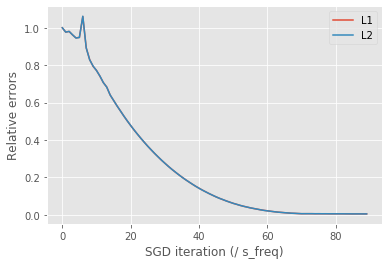

In [9]:
# 10D Heat equation approximation, u(0,x)=||x||2

T,N   = 1,1      # Time value we solve PDE for, number of discretization points to sample Ito diffusion
a,b = 0,1        # a,b in [a,b]^d
d   = 100         # d   in [a,b]^d
s   = 3          # total number of layers excluding input (including output, meaning we have s-1 hidden layers)
m   = 4500       # SGD iterations
J   = 8192       # Batch size
s_freq = 50     # Frequency at which we record losses
mc_freq = 1250 # How many MC samples to estimate test errors

learning_rate = 0.001

# The Ito diffusion corresponding to the Heat equation is Brownian motion. Here we define the initial condition as 
# u(0,x)=||x||2 (squared Euclidean norm) and via an Ansatz you can get the exact solution as u(t,x) = ||x||2 + 2td
brownian_motion = ItoDiffusion(lambda x: torch.zeros(x.size(0),x.size(1)), lambda x: torch.sqrt(torch.tensor(2.0)), 1)

phi = lambda x: torch.norm(x,2,1)**2
u   = lambda x: phi(x) + 2.0*T*d

# Creating our neural network model
model = FCNN(d,s-1)

# Setting the optimizer and setting the learning rate to decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3500, gamma=0.1)

L1_errors   = []
L2_errors   = []
Linf_errors = []

t = time.time()

best_params = model.state_dict()
min_loss = 10000

for i in range(m):
    eta  = (a-b)*torch.rand(J,d) + b
    X_T  = brownian_motion.sample(eta,T)
    loss = torch.mean((model(eta)[:,0]-phi(X_T))**2)
    
    if loss < min_loss:
        min_loss = loss
        best_params = model.state_dict()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if i%s_freq == 0:
        model.eval()
        L1_errors.append(Lp_error(model, a,b,d, mc_freq,1,u)[1])
        L2_errors.append(Lp_error(model, a,b,d, mc_freq,2,u)[1])
        Linf_errors.append(Lp_error(model, a,b,d, mc_freq,"max",u)[1])
        print("Step {} Relative L1 error is {:.5f} Relative L2 error is {:.5f}, Relative L∞ error is {:.5f}, in {:.4f} s".format(i,L1_errors[-1],L2_errors[-1],Linf_errors[-1],time.time() - t))
        t = time.time()
        model.train()


plt.plot(range(len(L1_errors)),L1_errors,range(len(L2_errors)),L2_errors)
plt.ylabel("Relative errors")
plt.xlabel("SGD iteration (/ s_freq)")
plt.legend(["L1", "L2"])
plt.savefig("L2Norm10DLoss.png")
plt.show()

Step 0 Relative L1 error is 1.08744 Relative L2 error is 1.08788, Relative L∞ error is 1.10701, in 0.0239 s
Step 50 Relative L1 error is 1.01823 Relative L2 error is 1.01724, Relative L∞ error is 1.15665, in 0.4720 s
Step 100 Relative L1 error is 0.94803 Relative L2 error is 0.95203, Relative L∞ error is 1.14793, in 0.4393 s
Step 150 Relative L1 error is 0.87615 Relative L2 error is 0.87710, Relative L∞ error is 1.15467, in 0.4298 s
Step 200 Relative L1 error is 0.75229 Relative L2 error is 0.75162, Relative L∞ error is 1.17656, in 0.4499 s
Step 250 Relative L1 error is 0.66089 Relative L2 error is 0.65998, Relative L∞ error is 1.07537, in 0.4432 s
Step 300 Relative L1 error is 0.60338 Relative L2 error is 0.59612, Relative L∞ error is 1.01429, in 0.4377 s
Step 350 Relative L1 error is 0.50974 Relative L2 error is 0.51526, Relative L∞ error is 0.92255, in 0.4306 s
Step 400 Relative L1 error is 0.40121 Relative L2 error is 0.40457, Relative L∞ error is 0.77037, in 0.4269 s
Step 450 Rela

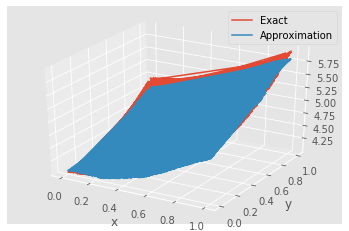

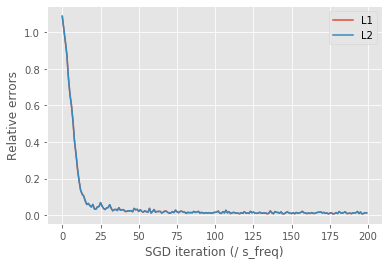

In [12]:
# 2D Heat equation approximation, u(0,x)=||x||2

T,N   = torch.tensor(1.0),1      # Time value we solve PDE for, number of discretization points to sample Ito diffusion
a,b = 0,1        # a,b in [a,b]^d
d   = 2         # d   in [a,b]^d
s   = 3          # total number of layers excluding input (including output, meaning we have s-1 hidden layers)
m   = 10000       # SGD iterations
J   = 8192       # Batch size
s_freq = 50     # Frequency at which we record losses
mc_freq = 1250 # How many MC samples to estimate test errors

learning_rate = 0.001

# The Ito diffusion corresponding to the Heat equation is Brownian motion. Here we define the initial condition as 
# u(0,x)=||x||2 (squared Euclidean norm) and via an Ansatz you can get the exact solution as u(t,x) = ||x||2 + 2td
brownian_motion = ItoDiffusion(lambda x: torch.zeros(x.size(0),x.size(1)), lambda x: torch.sqrt(torch.tensor(2.0)), N)
phi = lambda x: torch.norm(x,2,1)**2
u   = lambda x: phi(x) + 2.0*T*d


# Creating our neural network model
model = FCNN(d,s-1,neurons=10)

# Setting the optimizer and setting the learning rate to decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int((2*m)/3), gamma=0.1)

L1_errors   = []
L2_errors   = []
Linf_errors = []

best_params = model.state_dict()
min_loss = 10000

t = time.time()

for i in range(m):
    eta  = (a- b)*torch.rand(J,d) + b
    #eta = mvn(((b+a)/2)*torch.ones(d), 0.1*torch.eye(d)).sample([J])
    X_T  = brownian_motion.sample(eta,T)
    optimizer.zero_grad()
    loss = torch.mean((model(eta)[:,0]-phi(X_T))**2)
    if loss < min_loss:
        min_loss = loss
        best_params = model.state_dict() 
    
    loss.backward()
    optimizer.step()
    #scheduler.step()

    if i%s_freq == 0:
        model.eval()
        L1_errors.append(Lp_error(model, a,b,d, mc_freq,1,u)[1])
        L2_errors.append(Lp_error(model, a,b,d, mc_freq,2,u)[1])
        Linf_errors.append(Lp_error(model, a,b,d, mc_freq,"max",u)[1])

        
        print("Step {} Relative L1 error is {:.5f} Relative L2 error is {:.5f}, Relative L∞ error is {:.5f}, in {:.4f} s".format(i,L1_errors[-1],L2_errors[-1],Linf_errors[-1],time.time() - t))
        t = time.time()
        model.train()

model.load_state_dict(best_params)
inputs = (a- b)*torch.rand(10000,2) + b
model.eval()
U = model(inputs)[:,0]
inputs_np = inputs.detach().numpy()
U_np = U.detach().numpy()
u_np = u(inputs).detach().numpy()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(inputs_np[:,0],inputs_np[:,1],u_np)
ax.plot(inputs_np[:,0],inputs_np[:,1],U_np)
plt.legend(["Exact","Approximation"])
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.savefig("L2Norm2Dsolution.png")
plt.show()


plt.plot(range(len(L1_errors)),L1_errors,range(len(L2_errors)),L2_errors)
plt.ylabel("Relative errors")
plt.xlabel("SGD iteration (/ s_freq)")
plt.legend(["L1", "L2"])
plt.savefig("L2Norm2DsolutionLoss.png")
plt.show()

Step 0 Relative L1 error is 0.11365 Relative L2 error is 0.13066, Relative L∞ error is 0.24484, in 0.3885 s
Step 100 Relative L1 error is 0.02960 Relative L2 error is 0.03361, Relative L∞ error is 0.06722, in 1.0564 s
Step 200 Relative L1 error is 0.01169 Relative L2 error is 0.01402, Relative L∞ error is 0.02569, in 1.0425 s
Step 300 Relative L1 error is 0.02014 Relative L2 error is 0.02177, Relative L∞ error is 0.03466, in 1.0112 s
Step 400 Relative L1 error is 0.01574 Relative L2 error is 0.01779, Relative L∞ error is 0.03050, in 0.9602 s
Step 500 Relative L1 error is 0.00457 Relative L2 error is 0.00553, Relative L∞ error is 0.01158, in 0.9934 s
Step 600 Relative L1 error is 0.00736 Relative L2 error is 0.00856, Relative L∞ error is 0.01785, in 1.0068 s
Step 700 Relative L1 error is 0.02161 Relative L2 error is 0.02672, Relative L∞ error is 0.05856, in 1.0113 s
Step 800 Relative L1 error is 0.00903 Relative L2 error is 0.01058, Relative L∞ error is 0.01747, in 1.0276 s
Step 900 Rel

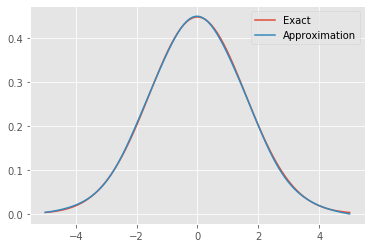

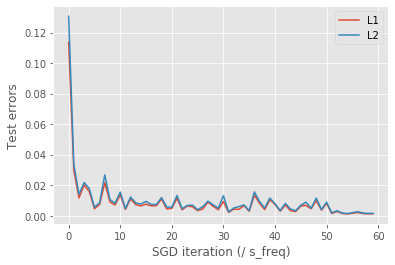

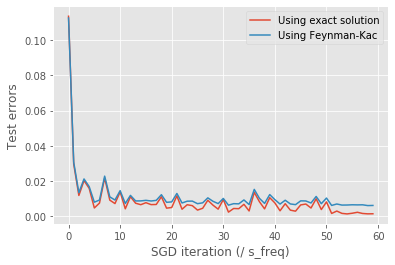

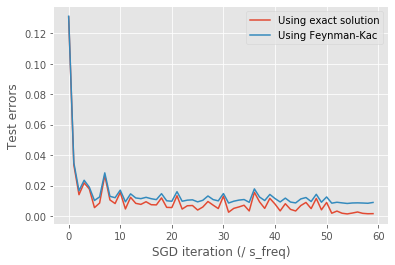

In [11]:
# 1D Heat equation approximation, u(0,x)=e^{-x^2}

T,N   = torch.tensor(1.0),1      # Time value we solve PDE for, number of discretization points to sample Ito diffusion
a,b = -5,5        # a,b in [a,b]^d
d   = 1         # d   in [a,b]^d
s   = 3         # total number of layers excluding input (including output, meaning we have s-1 hidden layers)
m   = 6000       # SGD iterations
J   = 8192       # Batch size
s_freq = 100     # Frequency at which we record losses
mc_freq = 1250 # How many MC samples to estimate test errors

learning_rate = 0.001

# The Ito diffusion corresponding to the Heat equation is Brownian motion.
brownian_motion = ItoDiffusion(lambda x: torch.zeros(x.size(0),x.size(1)), lambda x: torch.sqrt(torch.tensor(2.0)), N)


phi = lambda x: torch.exp(-(x**2))[:,0]
u   = lambda x: (torch.exp((-x**2)/(1+4*T))/(torch.sqrt(1+4*T)))[:,0]

# Creating our neural network model
model = FCNN(d,s-1,neurons=10)

# Setting the optimizer and setting the learning rate to decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)


L1_errors   = []
L2_errors   = []
Linf_errors = []

L1_errors_MC = []
L2_errors_MC = []


t = time.time()

best_params = model.state_dict()
min_loss = 10000


for i in range(m):
    eta  = (a-b)*torch.rand(J,d) + b
    X_T  = brownian_motion.sample(eta,T)
    
    loss = torch.mean((model(eta)[:,0]-phi(X_T))**2)
    
    
    if loss < min_loss:
        min_loss = loss
        best_params = model.state_dict() 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if i%s_freq == 0:
        model.eval()
        L1_errors.append(Lp_error(model,  a,b,d, mc_freq,1,u)[0])
        L2_errors.append(Lp_error(model, a,b,d, mc_freq,2,u)[0])
        L1_errors_MC.append(Lp_error(model, a,b,d, mc_freq,1,MC=1000,phi=phi,ito_diffusion=brownian_motion,T=T)[0])
        L2_errors_MC.append(Lp_error(model, a,b,d, mc_freq,2,MC=1000,phi=phi,ito_diffusion=brownian_motion,T=T)[0])
        Linf_errors.append(Lp_error(model,  a,b,d, mc_freq,"max",u)[0])
        print("Step {} Relative L1 error is {:.5f} Relative L2 error is {:.5f}, Relative L∞ error is {:.5f}, in {:.4f} s".format(i,L1_errors[-1],L2_errors[-1],Linf_errors[-1],time.time() - t))
        t = time.time()
        model.train()

domain = torch.linspace(a,b,100).reshape(100,1)
model.load_state_dict(best_params)
model.eval()
plt.plot(domain, u(domain), domain.detach().numpy(), model(domain)[:,0].detach().numpy())
plt.legend(["Exact","Approximation"])
plt.savefig("GaussianICSolution.png")
plt.show()

plt.plot(range(len(L1_errors)),L1_errors,range(len(L2_errors)),L2_errors)
plt.ylabel("Test errors")
plt.xlabel("SGD iteration (/ s_freq)")
plt.legend(["L1", "L2"])
plt.savefig("GaussianICError.png")
plt.show()

plt.plot(range(len(L1_errors)),L1_errors,range(len(L1_errors_MC)),L1_errors_MC)
plt.ylabel("Test errors")
plt.xlabel("SGD iteration (/ s_freq)")
plt.legend(["Using exact solution", "Using Feynman-Kac"])
plt.savefig("GaussianICL110d.png")
plt.show()

plt.plot(range(len(L2_errors)),L2_errors,range(len(L2_errors_MC)),L2_errors_MC)
plt.ylabel("Test errors")
plt.xlabel("SGD iteration (/ s_freq)")
plt.legend(["Using exact solution", "Using Feynman-Kac"])
plt.savefig("GaussianICL210d.png")
plt.show()

Step 0 Absolute L1 error is 2.16866 Absolute L2 error is 2.91770 in 0.4617 s
Step 100 Absolute L1 error is 3.40256 Absolute L2 error is 3.57562 in 1.1391 s
Step 200 Absolute L1 error is 1.71688 Absolute L2 error is 1.99561 in 1.1810 s
Step 300 Absolute L1 error is 1.83028 Absolute L2 error is 2.02104 in 1.2332 s
Step 400 Absolute L1 error is 0.88087 Absolute L2 error is 1.19896 in 1.2191 s
Step 500 Absolute L1 error is 0.61252 Absolute L2 error is 0.71114 in 1.3102 s
Step 600 Absolute L1 error is 1.63587 Absolute L2 error is 1.72617 in 1.4642 s
Step 700 Absolute L1 error is 1.56450 Absolute L2 error is 1.74328 in 1.1608 s
Step 800 Absolute L1 error is 0.97964 Absolute L2 error is 1.09417 in 1.1002 s
Step 900 Absolute L1 error is 1.18169 Absolute L2 error is 1.29823 in 1.1465 s
Step 1000 Absolute L1 error is 0.49345 Absolute L2 error is 0.54419 in 1.0474 s
Step 1100 Absolute L1 error is 0.36357 Absolute L2 error is 0.46272 in 1.4665 s
Step 1200 Absolute L1 error is 0.80513 Absolute L2 e

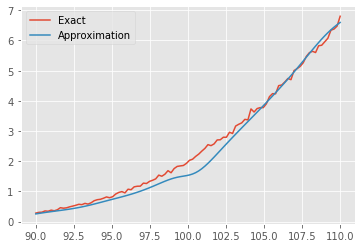

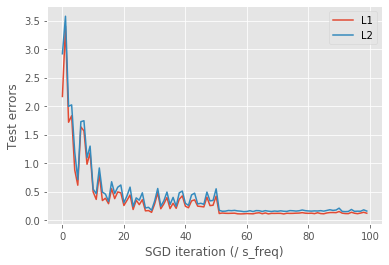

In [68]:
# Black-Scholes 1D

T,N   = torch.tensor(1.0),1     # Time value we solve PDE for, number of discretization points to sample Ito diffusion
a,b = 90,110        # a,b in [a,b]^d
d   = 1         # d   in [a,b]^d
s   = 3         # total number of layers excluding input (including output, meaning we have s-1 hidden layers)
m   = 10000       # SGD iterations
J   = 8192       # Batch size
s_freq = 100     # Frequency at which we record losses
mc_freq = 1250 # How many MC samples to estimate test errors
K = 100 # Black-Scholes formula constant

learning_rate = 0.001

# The Ito diffusion corresponding to the Black-Scholes equation is geometric brownian motion.
geo_brownian_motion = ItoDiffusion(lambda x: mu*x, lambda x: sigma*x, N)

r = 1.0/20
mu = torch.tensor(-1.0/20)
sigma = torch.tensor(1.0/10 + 1.0/200)

def phi(x):
    if len(x.shape) == 1:
        return (torch.exp(-r/T)*torch.max(x-K*torch.ones(x.shape[0]),torch.zeros(x.shape[0])))
    else:
        return (torch.exp(-r/T)*torch.max(x[:,0]-K*torch.ones(x.shape[0]),torch.zeros(x.shape[0])))

# Creating our neural network model
model = FCNN(d,s-1,neurons=10)

# Setting the optimizer and setting the learning rate to decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

L1_errors   = []
L2_errors   = []
Linf_errors = []

t = time.time()

best_params = model.state_dict()
min_loss = 10000
u_mean_at_T = 0

for i in range(m):
    eta  = (a-b)*torch.rand(J,d) + b
    X_T = geo_brownian_motion.sample(eta,T)[:,0]
    loss = torch.mean((model(eta)[:,0]-phi(X_T))**2)
    u_mean_at_T += torch.mean(phi(X_T))

    
    
    if loss < min_loss:
        min_loss = loss
        best_params = model.state_dict()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if i%s_freq == 0:
        model.eval()
        L1_errors.append(Lp_error(model,  a,b,d, mc_freq,1,MC=1000,phi=phi,ito_diffusion=geo_brownian_motion,T=T)[0])
        L2_errors.append(Lp_error(model, a,b,d, mc_freq,2,MC=1000,phi=phi,ito_diffusion=geo_brownian_motion,T=T)[0])
        print("Step {} Absolute L1 error is {:.5f} Absolute L2 error is {:.5f} in {:.4f} s".format(i,L1_errors[-1],L2_errors[-1],time.time() - t))
        t = time.time()
        model.train()


domain = torch.linspace(a,b,100).reshape(100,1)
u_true = lambda x: torch.mean(x*torch.exp(sigma*normal(0,1)))
model.load_state_dict(best_params)
model.eval()

true_u_euro = torch.zeros(100)
for i in range(100):
    true_u_euro[i] = torch.mean(phi(domain[i]*torch.exp(sigma*mvn(torch.zeros(d), T*torch.eye(d)).sample([J]) + (mu-0.5*(sigma**2))*T)))
plt.plot(domain, true_u_euro, domain.detach().numpy(), model(domain)[:,0].detach().numpy())
plt.legend(["Exact","Approximation"])
plt.savefig("BlackScholesEuro.png")
plt.show()

plt.plot(range(len(L1_errors)),L1_errors,range(len(L2_errors)),L2_errors)
plt.ylabel("Test errors")
plt.xlabel("SGD iteration (/ s_freq)")
plt.legend(["L1", "L2"])
plt.savefig("BlackScholesLossRelEuro.png")
plt.show()

Step 0 Absolute L1 error is 14.74434 Absolute L2 error is 15.22499, in 0.6086 s
Step 100 Absolute L1 error is 13.26214 Absolute L2 error is 13.31173, in 1.3093 s
Step 200 Absolute L1 error is 13.85323 Absolute L2 error is 13.83300, in 1.3734 s
Step 300 Absolute L1 error is 12.16052 Absolute L2 error is 12.28522, in 1.5948 s
Step 400 Absolute L1 error is 10.89896 Absolute L2 error is 10.80121, in 1.4168 s
Step 500 Absolute L1 error is 9.40048 Absolute L2 error is 9.29274, in 1.3272 s
Step 600 Absolute L1 error is 7.95049 Absolute L2 error is 8.04066, in 1.2929 s
Step 700 Absolute L1 error is 6.61357 Absolute L2 error is 7.02055, in 1.3783 s
Step 800 Absolute L1 error is 5.41639 Absolute L2 error is 5.65476, in 1.6171 s
Step 900 Absolute L1 error is 4.46652 Absolute L2 error is 4.69074, in 1.4992 s
Step 1000 Absolute L1 error is 3.54702 Absolute L2 error is 3.77237, in 1.6192 s
Step 1100 Absolute L1 error is 2.83393 Absolute L2 error is 2.98589, in 1.3856 s
Step 1200 Absolute L1 error is

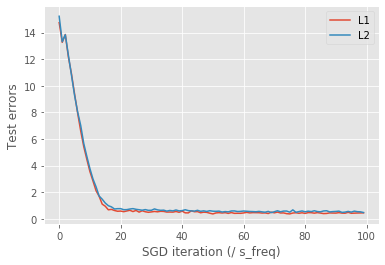

In [64]:
# Black-Scholes 10D European option pricing

T,N   = torch.tensor(1.0),1     # Time value we solve PDE for, number of discretization points to sample Ito diffusion
a,b = 90,110        # a,b in [a,b]^d
d   = 10         # d   in [a,b]^d
s   = 3         # total number of layers excluding input (including output, meaning we have s-1 hidden layers)
m   = 10000       # SGD iterations
J   = 8192       # Batch size
s_freq = 100     # Frequency at which we record losses
mc_freq = 100 # How many MC samples to estimate test errors
K = torch.tensor(100) # Black-Scholes formula constant

learning_rate = 0.001

# The Ito diffusion corresponding to the Black-Scholes equation is geometric brownian motion.
geo_brownian_motion = ItoDiffusion(lambda x: x*mu, lambda x: x@sigma, N)

r = 1.0/20
mu = torch.tensor(-1.0/20)*torch.ones(d)
sigma = torch.diag(torch.tensor([1.0/10 + i*(1.0/200) for i in range(0,d)]))

phi = lambda x: torch.exp(-r/T)*torch.max(torch.max(x,dim=1).values-K*torch.ones(x.shape[0]),torch.zeros(x.shape[0]))

# Creating our neural network model
model = FCNN(d,s-1)

# Setting the optimizer and setting the learning rate to decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)


L1_errors   = []
L2_errors   = []
Linf_errors = []

t = time.time()

best_params = model.state_dict()
min_loss = 10000
u_mean_at_T = 0

for i in range(m):
    eta  = (a-b)*torch.rand(J,d) + b
    X_T = geo_brownian_motion.sample(eta,T)
    loss = torch.mean((model(eta)[:,0]-phi(X_T))**2)
    u_mean_at_T += torch.mean(phi(X_T))
    
    if loss < min_loss:
        min_loss = loss
        best_params = model.state_dict()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if i%s_freq == 0:
        model.eval()
        L1_errors.append(Lp_error(model,  a,b,d, mc_freq,1,MC=1000,phi=phi,ito_diffusion=geo_brownian_motion,T=T)[0])
        L2_errors.append(Lp_error(model, a,b,d, mc_freq,2,MC=1000,phi=phi,ito_diffusion=geo_brownian_motion,T=T)[0])
        print("Step {} Absolute L1 error is {:.5f} Absolute L2 error is {:.5f}, in {:.4f} s".format(i,L1_errors[-1],L2_errors[-1],time.time() - t))
        t = time.time()
        model.train()

print(u_mean_at_T/m) # Mean of S
plt.plot(range(len(L1_errors)),L1_errors,range(len(L2_errors)),L2_errors)
plt.ylabel("Test errors")
plt.xlabel("SGD iteration (/ s_freq)")
plt.legend(["L1", "L2"])
plt.savefig("BlackScholesnDLossEuroCall.png")
plt.show()

Step 0 Absolute L1 error is 0.32378 Absolute L2 error is 0.31940, in 0.0737 s
Step 100 Absolute L1 error is 0.16337 Absolute L2 error is 0.18768, in 0.8989 s
Step 200 Absolute L1 error is 0.13044 Absolute L2 error is 0.14851, in 0.9020 s
Step 300 Absolute L1 error is 0.09944 Absolute L2 error is 0.13419, in 0.9117 s
Step 400 Absolute L1 error is 0.08841 Absolute L2 error is 0.12842, in 0.9015 s
Step 500 Absolute L1 error is 0.08642 Absolute L2 error is 0.09009, in 0.9053 s
Step 600 Absolute L1 error is 0.08426 Absolute L2 error is 0.11603, in 0.9388 s
Step 700 Absolute L1 error is 0.07203 Absolute L2 error is 0.11724, in 1.0394 s
Step 800 Absolute L1 error is 0.06223 Absolute L2 error is 0.12120, in 1.0214 s
Step 900 Absolute L1 error is 0.06562 Absolute L2 error is 0.10489, in 0.8925 s
Step 1000 Absolute L1 error is 0.07416 Absolute L2 error is 0.10341, in 0.8757 s
Step 1100 Absolute L1 error is 0.07656 Absolute L2 error is 0.11592, in 0.8884 s
Step 1200 Absolute L1 error is 0.06632 A

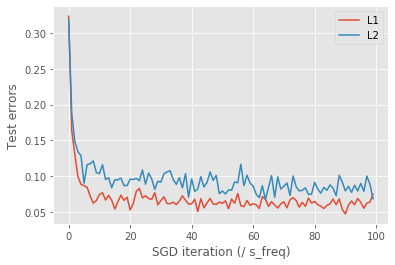

In [66]:
# Black-Scholes 10D Asian option call pricing

T,N   = torch.tensor(1.0),1     # Time value we solve PDE for, number of discretization points to sample Ito diffusion
a,b = 90,110        # a,b in [a,b]^d
d   = 10         # d   in [a,b]^d
s   = 3         # total number of layers excluding input (including output, meaning we have s-1 hidden layers)
m   = 10000       # SGD iterations
J   = 8192       # Batch size
s_freq = 100     # Frequency at which we record losses
mc_freq = 100 # How many MC samples to estimate test errors
K = torch.tensor(100) # Black-Scholes formula constant

learning_rate = 0.001

# The Ito diffusion corresponding to the Black-Scholes equation is geometric brownian motion.
geo_brownian_motion = ItoDiffusion(lambda x: x*mu, lambda x: x@sigma, N)

r = 1.0/20
mu = torch.tensor(-1.0/20)*torch.ones(d)
sigma = torch.diag(torch.tensor([1.0/10 + i*(1.0/200) for i in range(0,d)]))

phi = lambda x: torch.exp(-r/T)*torch.max(torch.mean(x,dim=1)-K*torch.ones(x.shape[0]),torch.zeros(x.shape[0]))

# Creating our neural network model
model = FCNN(d,s-1)

# Setting the optimizer and setting the learning rate to decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)


L1_errors   = []
L2_errors   = []
Linf_errors = []

t = time.time()

best_params = model.state_dict()
min_loss = 10000
u_mean_at_T = 0

for i in range(m):
    eta  = (a-b)*torch.rand(J,d) + b
    X_T = geo_brownian_motion.sample(eta,T)
    loss = torch.mean((model(eta)[:,0]-phi(X_T))**2)
    u_mean_at_T += torch.mean(phi(X_T))
    
    if loss < min_loss:
        min_loss = loss
        best_params = model.state_dict()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if i%s_freq == 0:
        model.eval()
        L1_errors.append(Lp_error(model,  a,b,d, mc_freq,1,MC=100,phi=phi,ito_diffusion=geo_brownian_motion,T=T)[0])
        L2_errors.append(Lp_error(model, a,b,d, mc_freq,2,MC=100,phi=phi,ito_diffusion=geo_brownian_motion,T=T)[0])
        print("Step {} Absolute L1 error is {:.5f} Absolute L2 error is {:.5f}, in {:.4f} s".format(i,L1_errors[-1],L2_errors[-1],time.time() - t))
        t = time.time()
        model.train()

print(u_mean_at_T/m) # Mean of S
plt.plot(range(len(L1_errors)),L1_errors,range(len(L2_errors)),L2_errors)
plt.ylabel("Test errors")
plt.xlabel("SGD iteration (/ s_freq)")
plt.legend(["L1", "L2"])
plt.savefig("BlackScholesnDLossAsianCall.png")
plt.show()

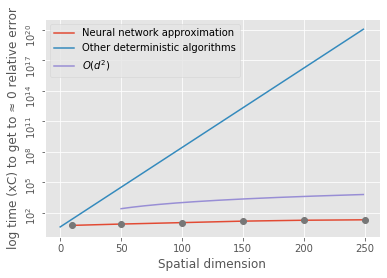

In [57]:
# Curve of dimensionality over one iteration
ds = [10,50,100,150,200,250]
times = []
m_ds = 1000

def train_step(d):
    start=time.time()
    for i in range(m_ds):
        eta_ds = (a-b)*torch.rand(J,d) + b
        optimizer.zero_grad()
        X_T  = brownian_motion.sample(eta,T)
        loss = torch.mean((model(eta)[:,0]-phi(X_T))**2)
        loss.backward()
        optimizer.step()
        scheduler.step()
    return time.time()-start
    
    
for d in ds:
    times.append(train_step(d))


plt.semilogy(ds,times)
plt.ylabel("log time (xC) to get to ≈ 0 relative error")
plt.xlabel("Spatial dimension")
plt.yticks(rotation='vertical')
plt.semilogy(np.arange(250),4*np.exp(0.18*np.arange(250)))
plt.semilogy(np.arange(250)[50:],0.1*np.arange(250)[50:]**2)
plt.legend(["Neural network approximation","Other deterministic algorithms","$O(d^2)$"])
plt.savefig("overcomingcurse.png")
plt.semilogy(ds,times,'o')
plt.show()